In [1]:
import torch
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from models.PropertyRegressors import PropertyRegressors
from datasets.get_fingerprints import get_fingerprints
from datasets.get_molecular_descriptors import get_molecular_descriptors
from datasets.get_chembert2as import get_chembert2as
from datasets.get_molformers import get_molformers

from tqdm import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"

descriptors = get_molecular_descriptors(task='classification').to(device)
print(f"descriptor tensor shape: {descriptors.shape}")  # [num_samples, 210]

fingerprints, label_tensor = get_fingerprints(task='classification')
print(f"fingerprint tensor shape: {fingerprints.shape}")  # [num_samples, 2048]

chembert2as = get_chembert2as(task='classification').to(device)
print(f"chembert2a tensor shape: {chembert2as.shape}")  # [num_samples, 600]

molformers = get_molformers(task='classification').to(device)
print(f"molformers tensor shape: {molformers.shape}")  # [num_samples, 768]

# train(descriptors, fingerprints, chembert2as, molformers, label_tensor)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
get_molecular_descriptors: 100%|██████████| 7807/7807 [01:16<00:00, 102.54it/s]


descriptor tensor shape: torch.Size([7807, 210])


get_fingerprints: 100%|██████████| 7807/7807 [00:01<00:00, 6080.74it/s]


fingerprint tensor shape: torch.Size([7807, 2048])


get_chembert2as: 100%|██████████| 7807/7807 [00:22<00:00, 353.05it/s]


chembert2a tensor shape: torch.Size([7807, 600])


get_molformers: 100%|██████████| 7807/7807 [03:00<00:00, 43.19it/s]

molformers tensor shape: torch.Size([7807, 768])


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class MolecularDataset(Dataset):
    def __init__(self, descriptors, fingerprints, chembert2as, molformers, labels):
        """
        Initialize the dataset with the different molecular representations
        
        Args:
            descriptors (torch.Tensor): Shape [7807, 210]
            fingerprints (torch.Tensor): Shape [7807, 2048]
            chembert2as (torch.Tensor): Shape [7807, 600]
            molformers (torch.Tensor): Shape [7807, 768]
            labels (torch.Tensor): Shape [7807]
        """
        self.descriptors = descriptors
        self.fingerprints = fingerprints
        self.chembert2as = chembert2as
        self.molformers = molformers
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        """
        Return a single sample from the dataset
        
        Args:
            idx (int): Index of the sample to return
            
        Returns:
            dict: Dictionary containing all features and label for the sample
        """
        sample = {
            'descriptors': self.descriptors[idx],
            'fingerprints': self.fingerprints[idx],
            'chembert2as': self.chembert2as[idx],
            'molformers': self.molformers[idx],
            'label': self.labels[idx]
        }
        return sample

# Example usage:
def create_data_loaders(descriptors, fingerprints, chembert2as, molformers, labels, 
                       batch_size=32, train_split=0.8, random_seed=42):
    """
    Create train and validation data loaders
    
    Args:
        descriptors (torch.Tensor): Molecular descriptors
        fingerprints (torch.Tensor): Molecular fingerprints
        chembert2as (torch.Tensor): ChemBERT embeddings
        molformers (torch.Tensor): Molformer embeddings
        labels (torch.Tensor): Target labels
        batch_size (int): Batch size for the data loaders
        train_split (float): Proportion of data to use for training
        random_seed (int): Random seed for reproducibility
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    # Set random seed for reproducibility
    torch.manual_seed(random_seed)
    
    # Calculate split indices
    dataset_size = len(labels)
    indices = torch.randperm(dataset_size)
    train_size = int(train_split * dataset_size)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # Create train dataset
    train_dataset = MolecularDataset(
        descriptors[train_indices],
        fingerprints[train_indices],
        chembert2as[train_indices],
        molformers[train_indices],
        labels[train_indices]
    )
    
    # Create validation dataset
    val_dataset = MolecularDataset(
        descriptors[val_indices],
        fingerprints[val_indices],
        chembert2as[val_indices],
        molformers[val_indices],
        labels[val_indices]
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, val_loader


In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

train_loader, val_loader = create_data_loaders(
    descriptors=descriptors,
    fingerprints=fingerprints,
    chembert2as=chembert2as,
    molformers=molformers,
    labels=label_tensor,
    batch_size=1000
)

In [326]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat, reduce, einsum

from models.DifferentialAttention import DiffAttn

class PropertyRegressor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        hid_dim: int, 
        out_dim: int,
    ):
        super().__init__()
        
        self.diff_attn = DiffAttn(in_dim, hid_dim, depth=0)
        self.diff_attn = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.Dropout(0.2),
            nn.GELU(),
            )
        self.diff_attn = nn.Sequential(
            nn.Conv2d(1,2,(2,2048))
        )
        self.to_property = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(hid_dim, hid_dim),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(hid_dim, out_dim),
        )
    
    def forward(
        self,
        x: Tensor,
    ) -> Tensor:
        
        x = self.diff_attn(x)
        return self.to_property(x)

class PropertyRegressors(nn.Module):
    def __init__(
        self,
        hid_dim,
        out_dim,
    ):
        super().__init__()
        
        self.rdkit = PropertyRegressor(210, hid_dim, out_dim)
        self.morgan = PropertyRegressor(2048, hid_dim, out_dim)
        self.chembert2a = PropertyRegressor(600, hid_dim, out_dim)
        self.molformer = PropertyRegressor(768, hid_dim, out_dim)
        
        self.lambdas = nn.Parameter(torch.ones([4,1]))
        
        self.rdkit_norm = nn.InstanceNorm1d(210)
        self.morgan_norm = nn.InstanceNorm1d(2048)
        self.chembert2a_norm = nn.InstanceNorm1d(600)
        self.molformer_norm = nn.InstanceNorm1d(768)
    
    def forward(
        self,
        rdkit: Tensor,
        morgan: Tensor,
        chembert2a: Tensor,
        molformer: Tensor,
    ) -> tuple[Tensor, Tensor]:
        # print(self.lambdas)
        
        rdkit = self.rdkit_norm(rdkit)
        morgan = self.morgan_norm(morgan)
        chembert2a = self.chembert2a_norm(chembert2a)
        molformer = self.molformer_norm(molformer)
        
        rdkit_out = self.rdkit(rdkit)
        morgan_out = self.morgan(morgan)
        chembert2a_out = self.chembert2a(chembert2a)
        molformer_out = self.molformer(molformer)
        
        before_vote = torch.stack([
            rdkit_out,
            morgan_out,
            chembert2a_out,
            molformer_out,
        ], dim=1)  # shape: [batch_size, 4, out_dim]
        
        normalized_lambdas = F.softmax(self.lambdas, dim=0)
        lambdas = repeat(normalized_lambdas, 'four one -> batch_size four one', batch_size=rdkit.shape[0])
        
        after_vote = torch.einsum('bfo,bfo->bo', lambdas, before_vote)
        
        return after_vote.sigmoid(), normalized_lambdas

In [327]:
from torchmetrics import AUROC

# Initialize model, optimizer, and loss function
model = PropertyRegressors(128, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
epoch_loss = 0.0
epoch_val_loss = 0.0

auroc = AUROC(task="binary")

train_losses = []
val_losses = []

train_aurocs = []
val_aurocs = []

train_lambdas = []

for epoch in tqdm(range(50)):
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        desc = batch['descriptors']          # Shape: [batch_size, 210]
        fps = batch['fingerprints']          # Shape: [batch_size, 2048]
        chembert = batch['chembert2as']      # Shape: [batch_size, 600]
        molformer = batch['molformers']      # Shape: [batch_size, 768]
        labels = batch['label']              # Shape: [batch_size]
        
        # desc = torch.ones_like(desc)
        # fps = torch.zeros_like(fps)
        # chembert = torch.ones_like(chembert)
        # molformer = torch.ones_like(molformer)
        
        # Forward pass
        predictions, lambdas = model(desc, fps, chembert, molformer)
        # print(predictions)
        # Calculate loss
        loss = criterion(predictions, labels.view(-1,1))
        auroc(predictions, labels.view(-1,1))
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    # Print epoch results
    avg_epoch_loss = epoch_loss / len(train_loader)
    report_lambdas = list(lambdas.detach().cpu())
    
    train_losses.append(avg_epoch_loss)
    train_aurocs.append(auroc.compute())
    train_lambdas.append(report_lambdas)
    # print(f'Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}. AUROC: {auroc.compute():.4f}. Lambdas: {report_lambdas}')
    epoch_loss = 0.0
    auroc.reset()
    
    with torch.no_grad():
        last_epoch_val_predictions = torch.tensor([])
        last_epoch_val_labels = torch.tensor([])
        for batch in val_loader:
            optimizer.zero_grad()
            
            desc = batch['descriptors']          # Shape: [batch_size, 210]
            fps = batch['fingerprints']          # Shape: [batch_size, 2048]
            chembert = batch['chembert2as']      # Shape: [batch_size, 600]
            molformer = batch['molformers']      # Shape: [batch_size, 768]
            val_labels = batch['label']              # Shape: [batch_size]
            
            # desc = torch.ones_like(desc)
            # fps = torch.zeros_like(fps)
            # chembert = torch.ones_like(chembert)
            # molformer = torch.ones_like(molformer)
            
            # Forward pass
            val_predictions, val_lambdas = model(desc, fps, chembert, molformer)
            # print(predictions)
            # Calculate loss
            loss = criterion(val_predictions, val_labels.view(-1,1))
            auroc(val_predictions, val_labels.view(-1,1))
            
            # Backward pass and optimization
            
            epoch_val_loss += loss.item()
            last_epoch_val_predictions = torch.cat((last_epoch_val_predictions, val_predictions),dim=0)
            last_epoch_val_labels = torch.cat((last_epoch_val_labels, val_labels),dim=0)
        # Print epoch results
        avg_epoch_loss = epoch_val_loss / len(val_loader)
        report_lambdas = list(lambdas.detach().cpu())
        # print(f'Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}. AUROC: {auroc.compute():.4f}. (Val)')
        # print(lambdas)
        val_losses.append(avg_epoch_loss)
        val_aurocs.append(auroc.compute())
        epoch_val_loss = 0.0
        auroc.reset()
print(lambdas)


RuntimeError: expand(torch.FloatTensor{[1024, 1024]}, size=[1024]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

AUROC: 0.939


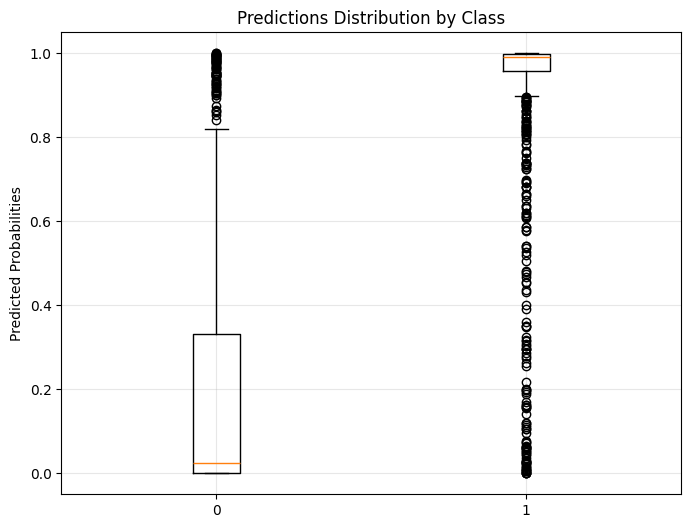

In [305]:
import matplotlib.pyplot as plt
from torchmetrics import AUROC

# Reset and compute AUROC
print(f"AUROC: {val_aurocs[-1]:.3f}")

# Convert to numpy for plotting
L = last_epoch_val_labels.view(-1,1).detach().cpu().numpy()
P = last_epoch_val_predictions.detach().cpu().numpy()

# Create box plot
plt.figure(figsize=(8, 6))
plt.boxplot([P[L.flatten() == 0].flatten(), P[L.flatten() == 1].flatten()], 
            labels=['0', '1'])
plt.ylabel('Predicted Probabilities')
plt.title('Predictions Distribution by Class')
plt.grid(True, alpha=0.3)
plt.show()

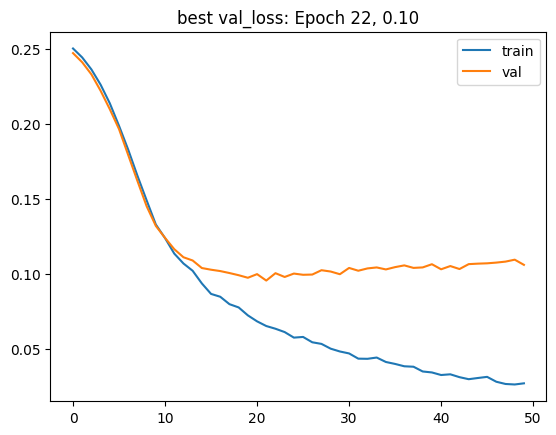

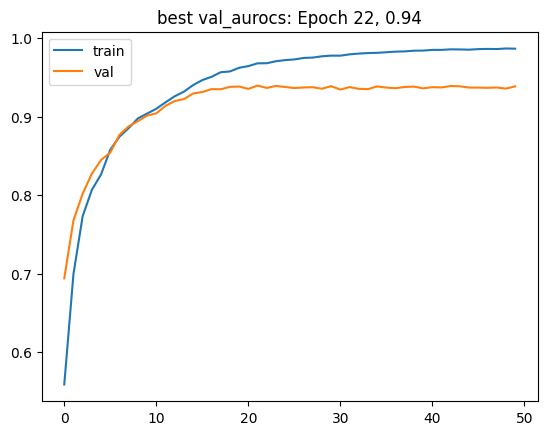

In [306]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
best_epoch = np.argmin(val_losses)
plt.title(f'best val_loss: Epoch {best_epoch+1}, {val_losses[best_epoch]:.2f}')
plt.legend()
plt.show()

plt.plot(train_aurocs, label='train')
plt.plot(val_aurocs, label='val')
best_epoch = np.argmin(val_losses)
plt.title(f'best val_aurocs: Epoch {best_epoch+1}, {val_aurocs[best_epoch]:.2f}')
plt.legend()
plt.show()

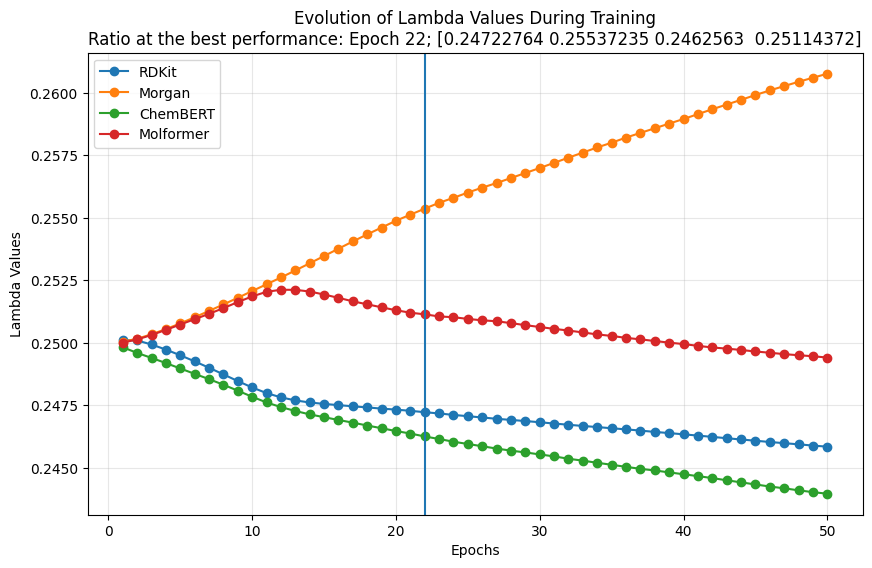

In [307]:
import numpy as np

# Convert list of lambdas to numpy array for easier plotting
lambdas_array = np.array(train_lambdas)  # shape: [n_epochs, 4, 1]
lambdas_array = lambdas_array.squeeze()  # shape: [n_epochs, 4]

plt.figure(figsize=(10, 6))
epochs = range(1, len(train_lambdas) + 1)

# Plot each lambda
Ls = ['RDKit', 'Morgan', 'ChemBERT', 'Molformer']
for i in range(4):
    plt.plot(epochs, lambdas_array[:, i], label=Ls[i], marker='o')

plt.xlabel('Epochs')
plt.ylabel('Lambda Values')
plt.title(f'Evolution of Lambda Values During Training\nRatio at the best performance: Epoch {best_epoch+1}; {lambdas_array[best_epoch]}')
plt.axvline(best_epoch+1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

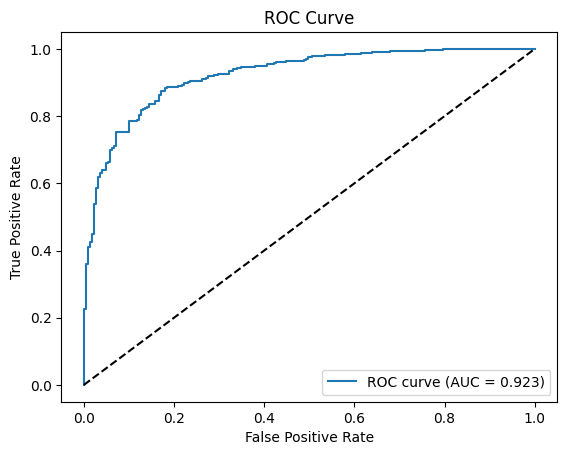

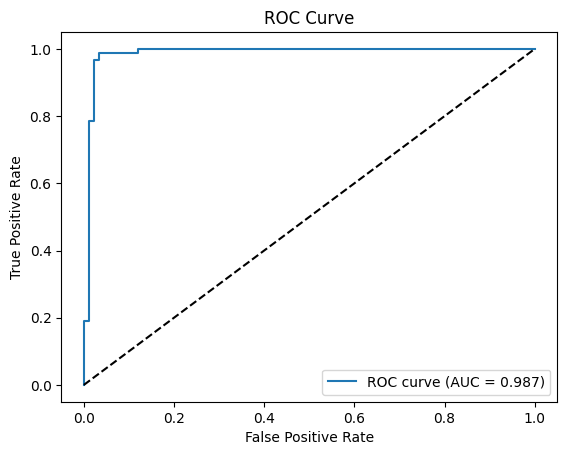

In [308]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels, predictions):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    # Plotting
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Usage:
plot_roc_curve(
    val_labels.view(-1,1).detach().cpu().numpy(),
    val_predictions.detach().cpu().numpy()
)

plot_roc_curve(
    labels.view(-1,1).detach().cpu().numpy(),
    predictions.detach().cpu().numpy()
)